# Определение перспективного тарифа для телеком компании

[Введение](#beginning)

1. [Изучение общей информации](#start)


2. [Подготовка данных](#preprocessing)

    2.1. [Подготовка данных в таблице users](#users)
    
    2.2. [Подготовка данных в таблице tariffs](#tariffs)   
    
    2.3. [Подготовка данных в таблице calls](#calls)  
    
    2.4. [Подготовка данных в таблице internet](#internet) 
    
    2.5. [Подготовка данных в таблице messages](#messages) 
 

3. [Анализ данных](#analysis)


4. [Проверка гипотез](#assumption)

   
 
5. [Общий вывод](#finalizing)  


<a id="beginning"></a>
## Введение

В ходе данной работы будут проанализированы два тарифа оператора сотовой связи - компании Мегалайн: Смарт и Ультра; описано поведение клиентов оператора исходя из имеющейся выборки в 500 абонентов за 2018 год и проверены статистические гипотезы о равенстве выручек для тарифов Смарт и Ультра для принятия решения о распределении рекламного бюджета между тарифами.
Кроме того, будет проверена статистическая гипотеза о равенстве выручек для Москвы и регионов.

<a id="start"></a>
## 1. Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
m = Mystem() 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
from scipy import stats as st
from math import factorial
from datetime import datetime


calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
current_date = datetime.now().date()
last_date_2018 = ('2018-12-31')
current_date

datetime.date(2021, 1, 31)

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


In [4]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.950,2018-11-25,1000
1,1,1000_1,1052.810,2018-09-07,1000
2,2,1000_2,1197.260,2018-06-25,1000
3,3,1000_3,550.270,2018-08-22,1000
4,4,1000_4,302.560,2018-09-24,1000


In [5]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [13]:
users.describe()

,user_id,age
count,500.000,500.000
mean,1249.500,46.588
std,144.482,16.668
min,1000.000,18.000
25%,1124.750,32.000
50%,1249.500,46.000
75%,1374.250,62.000
max,1499.000,75.000


***Вывод***

Данные представлены в 5 отдельных таблицах, которые нужно будет объединить для решения поставленной задачи.
Пропусков практически нет.

<a id="preprocessing"></a>
## 2. Подготовка данных

<a id="users"></a>
###  2.1. Подготовка данных в таблице users

В таблице users поменяем типы данных в столбцах user_id и age на наиболее подходящие uint16 и uint8 для экономии места.
В столбцах churn_date и reg_date изменим тип данных на формат даты и времени.
Пропуски есть только в столбце churn_date. Заполним пропущенные значения сегодняшней датой.


In [14]:
users['user_id'] = users['user_id'].astype('uint16')
users['age'] = users['age'].astype('uint8')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%dT%H:%M:%S')
users['churn_date'] = users['churn_date'].fillna(last_date_2018)
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%dT%H:%M:%S')
users['reg_month'] = users['reg_date'].dt.month
users['reg_month'] = users['reg_month'].astype('uint8')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id       500 non-null uint16
age           500 non-null uint8
churn_date    500 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
reg_month     500 non-null uint8
dtypes: datetime64[ns](2), object(4), uint16(1), uint8(2)
memory usage: 25.5+ KB


In [15]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


<a id="tariffs"></a>
###  2.2. Подготовка данных в таблице tariffs

In [16]:
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000,2.000,2.000,2.000,2.000,2.000,2.000
mean,525.000,23040.000,1750.000,1250.000,175.000,2.000,2.000
std,671.751,10861.160,1767.767,989.949,35.355,1.414,1.414
min,50.000,15360.000,500.000,550.000,150.000,1.000,1.000
25%,287.500,19200.000,1125.000,900.000,162.500,1.500,1.500
50%,525.000,23040.000,1750.000,1250.000,175.000,2.000,2.000
75%,762.500,26880.000,2375.000,1600.000,187.500,2.500,2.500
max,1000.000,30720.000,3000.000,1950.000,200.000,3.000,3.000


В таблице Тарифы только 2 строки, пропусков и ошибок в данных нет, просто поменяем типы данных на более подходящие uint8 и uint16 для экономии места. Добавим столбец с количеством включенных в тариф Гб

In [17]:
tariffs['messages_included'] = tariffs['messages_included'].astype('uint16')
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'].astype('uint16')
tariffs['minutes_included'] = tariffs['minutes_included'].astype('uint16')
tariffs['rub_monthly_fee'] = tariffs['rub_monthly_fee'].astype('uint16')
tariffs['rub_per_gb'] = tariffs['rub_per_gb'].astype('uint16')
tariffs['rub_per_message'] = tariffs['rub_per_message'].astype('uint8')
tariffs['rub_per_minute'] = tariffs['rub_per_minute'].astype('uint8')
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs['gb_per_month_included'] = tariffs['gb_per_month_included'].astype('uint8')

Создадим срезы отдельно по тарифам.

In [18]:
tariffs_smart = tariffs.query('tariff_name=="smart"')
tariffs_ultra = tariffs.query('tariff_name=="ultra"')

In [19]:
tariffs_smart

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15


In [20]:
tariffs_ultra

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
1,1000,30720,3000,1950,150,1,1,ultra,30


Сохраним тарифы в переменных для дальнейшего использования

In [21]:
messages_included_smart = tariffs_smart.loc[0,'messages_included']
minutes_included_smart = tariffs_smart.loc[0,'minutes_included']
gb_per_month_included_smart = tariffs_smart.loc[0,'gb_per_month_included']
rub_monthly_fee_smart = tariffs_smart.loc[0,'rub_monthly_fee']
rub_per_gb_fee_smart = tariffs_smart.loc[0,'rub_per_gb']
rub_per_message_smart = tariffs_smart.loc[0,'rub_per_message']
rub_per_minute_smart = tariffs_smart.loc[0,'rub_per_minute']

In [22]:
messages_included_ultra = tariffs_ultra.loc[1,'messages_included']
minutes_included_ultra = tariffs_ultra.loc[1,'minutes_included']
gb_per_month_included_ultra = tariffs_ultra.loc[1,'gb_per_month_included']
rub_monthly_fee_ultra = tariffs_ultra.loc[1,'rub_monthly_fee']
rub_per_gb_fee_ultra = tariffs_ultra.loc[1,'rub_per_gb']
rub_per_message_ultra = tariffs_ultra.loc[1,'rub_per_message']
rub_per_minute_ultra = tariffs_ultra.loc[1,'rub_per_minute']

In [23]:
print(messages_included_smart)
print(minutes_included_smart)
print(gb_per_month_included_smart) 
print(rub_monthly_fee_smart)
print(rub_per_gb_fee_smart)
print(rub_per_message_smart)
print(rub_per_minute_smart)

50
500
15
550
200
3
3


In [24]:
print(messages_included_ultra)
print(minutes_included_ultra)
print(gb_per_month_included_ultra) 
print(rub_monthly_fee_ultra)
print(rub_per_gb_fee_ultra)
print(rub_per_message_ultra)
print(rub_per_minute_ultra)

1000
3000
30
1950
150
1
1


<a id="calls"></a>
###  2.3. Подготовка данных в таблице calls

In [25]:
calls.describe()

,duration,user_id
count,202607.000,202607.000
mean,6.756,1253.941
std,5.843,144.723
min,0.000,1000.000
25%,1.300,1126.000
50%,6.000,1260.000
75%,10.700,1379.000
max,38.000,1499.000


Приведём столбцы к форматам даты, а также сократим место, используя форматы uint16 и uint8. Добавим столбец с месяцем совершения звонка. Создадим столбец с округлённым по правилам компании Магалайн временем звонков. 
Нулевые звонки удалять не будем, т.к. в дальнейшем будет использована сгруппированная таблица.
Сгруппируем таблицу по пользователям и месяцам.

In [26]:
calls['user_id'] = calls['user_id'].astype('uint16')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
calls['duration_round'] = calls['duration']


In [27]:
def round_up(n):
    return math.ceil(n)

In [28]:
print(round_up(10.5))
print(round_up(10.4))
print(round_up(10))

11
11
10


In [29]:
calls['duration_round'] = calls['duration_round'].apply(round_up)
calls['duration_round'] = calls['duration_round'].astype('uint16')
calls['month'] = calls['call_date'].dt.month
calls['month'] = calls['month'].astype('uint8')

In [30]:
calls.describe()

,duration,user_id,duration_round,month
count,202607.000,202607.000,202607.000,202607.000
mean,6.756,1253.941,7.158,8.574
std,5.843,144.723,5.959,2.787
min,0.000,1000.000,0.000,1.000
25%,1.300,1126.000,2.000,7.000
50%,6.000,1260.000,6.000,9.000
75%,10.700,1379.000,11.000,11.000
max,38.000,1499.000,38.000,12.000


In [31]:
calls.head()

,id,call_date,duration,user_id,duration_round,month
0,1000_0,2018-07-25,0.000,1000,0,7
1,1000_1,2018-08-17,0.000,1000,0,8
2,1000_2,2018-06-11,2.850,1000,3,6
3,1000_3,2018-09-21,13.800,1000,14,9
4,1000_4,2018-12-15,5.180,1000,6,12


In [32]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 6 columns):
id                202607 non-null object
call_date         202607 non-null datetime64[ns]
duration          202607 non-null float64
user_id           202607 non-null uint16
duration_round    202607 non-null uint16
month             202607 non-null uint8
dtypes: datetime64[ns](1), float64(1), object(1), uint16(2), uint8(1)
memory usage: 5.6+ MB


In [33]:
calls_grouped = calls.groupby(['user_id', 'month']).agg({'duration_round': ['sum', 'count']})
calls_grouped.columns = ['duration_round', 'calls_count']

In [34]:
calls_grouped.head(20)

duration_round  calls_count
user_id month                             
1000    5                 159           22
        6                 172           43
        7                 340           47
        8                 408           52
        9                 466           58
        10                350           57
        11                338           43
        12                333           46
1001    11                430           59
        12                414           63
1002    6                 117           15
        7                 214           26
        8                 289           42
        9                 206           36
        10                212           33
        11                243           32
        12                236           33
1003    8                 380           55
        9                 961          134
        10                855          108

In [35]:
calls_grouped.describe()

,duration_round,calls_count
count,3174.000,3174.000
mean,456.932,63.833
std,238.031,32.678
min,0.000,1.000
25%,290.000,41.000
50%,447.000,63.000
75%,592.000,83.000
max,1673.000,244.000


In [36]:
calls_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
duration_round    3174 non-null uint16
calls_count       3174 non-null int64
dtypes: int64(1), uint16(1)
memory usage: 44.3 KB


In [115]:
calls_grouped.query('duration_round == 0')

duration_round  calls_count
user_id month                             
1240    2                   0            2
1257    7                   0            1
        8                   0            2
        9                   0            1
1373    1                   0            2
        4                   0            1

Произведём проверку - после группировки в получившейся таблице, которая и будет в дальнейшем использоваться для анализа, осталось всего лишь 6 строк с нулевыми значениями по длительности звонков. Остальные нулевые значения никак на результат влиять не будут. А данные 6 строк важно сохранить, чтобы учесть при анализе поведения пользователей  и иметь возможность рассчитать наиболее оптимальные тарифные планы. Поэтому принимаем решение нулевые звонки не удалять.

<a id="internet"></a>
###  2.4. Подготовка данных в таблице internet

In [37]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000,149396.000,149396.000
mean,74697.500,370.192,1252.100
std,43127.055,278.301,144.051
min,0.000,0.000,1000.000
25%,37348.750,138.188,1130.000
50%,74697.500,348.015,1251.000
75%,112046.250,559.553,1380.000
max,149395.000,1724.830,1499.000


В таблице internet удалим столбец с порядковыми номерами записей, столбец session_date переведём в формат даты, а также добавим столбец с месяцем сессии, столбец user_id переведём в наиболее подходящий формат uint16. Столбец mb_used округлим по правилам компании Мегалайн в бОльшую сторону и переведём в uint32 для экономии места. Затем создадим сгруппированную по пользователям и месяцам таблицу, куда добавим столбец с израсходованными гигабайтами, также округлёнными в бОльшую сторону, в формате uint16.

In [38]:
new_names = ['number', 'id', 'mb_used', 'session_date', 'user_id']
internet.set_axis(new_names, axis = 'columns', inplace = True)
print(internet.columns)

Index(['number', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')


In [39]:
del internet['number']
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.950,2018-11-25,1000
1,1000_1,1052.810,2018-09-07,1000
2,1000_2,1197.260,2018-06-25,1000
3,1000_3,550.270,2018-08-22,1000
4,1000_4,302.560,2018-09-24,1000


In [40]:
internet['user_id'] = internet['user_id'].astype('uint16')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%dT%H:%M:%S')

In [41]:
internet['mb_used_round'] = internet['mb_used'].apply(round_up)
internet['mb_used_round'] = internet['mb_used_round'].astype('uint32')
internet['month'] = internet['session_date'].dt.month

In [42]:
internet.head()

,id,mb_used,session_date,user_id,mb_used_round,month
0,1000_0,112.950,2018-11-25,1000,113,11
1,1000_1,1052.810,2018-09-07,1000,1053,9
2,1000_2,1197.260,2018-06-25,1000,1198,6
3,1000_3,550.270,2018-08-22,1000,551,8
4,1000_4,302.560,2018-09-24,1000,303,9


In [43]:
internet.describe()

,mb_used,user_id,mb_used_round,month
count,149396.000,149396.000,149396.000,149396.000
mean,370.192,1252.100,370.622,8.563
std,278.301,144.051,278.387,2.789
min,0.000,1000.000,0.000,1.000
25%,138.188,1130.000,139.000,7.000
50%,348.015,1251.000,349.000,9.000
75%,559.553,1380.000,560.000,11.000
max,1724.830,1499.000,1725.000,12.000


In [44]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
id               149396 non-null object
mb_used          149396 non-null float64
session_date     149396 non-null datetime64[ns]
user_id          149396 non-null uint16
mb_used_round    149396 non-null uint32
month            149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), uint16(1), uint32(1)
memory usage: 5.4+ MB


In [45]:
internet_grouped = internet.groupby(['user_id', 'month']).agg({'mb_used_round': ['sum']})
internet_grouped.columns = ['mb_used_round']

In [46]:
internet_grouped['gb_used'] = (internet_grouped['mb_used_round']/1024).apply(round_up)
internet_grouped['gb_used'] = internet_grouped['gb_used'].astype('uint16')

In [47]:
internet_grouped.head(20)

mb_used_round  gb_used
user_id month                        
1000    5               2256        3
        6              23257       23
        7              14016       14
        8              14070       14
        9              14581       15
        10             14717       15
        11             14768       15
        12              9827       10
1001    11             18452       19
        12             14053       14
1002    6              10871       11
        7              17601       18
        8              20347       20
        9              16712       17
        10             13905       14
        11             18610       19
        12             18137       18
1003    8               8571        9
        9              12479       13
        10             14779       15

In [48]:
internet_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
mb_used_round    3203 non-null uint32
gb_used          3203 non-null uint16
dtypes: uint16(1), uint32(1)
memory usage: 32.2 KB


In [49]:
internet_grouped.describe()

,mb_used_round,gb_used
count,3203.000,3203.000
mean,17286.750,17.389
std,7523.580,7.355
min,0.000,0.000
25%,12543.000,13.000
50%,16985.000,17.000
75%,21455.500,21.000
max,49789.000,49.000


<a id="messages"></a>
###  2.5. Подготовка данных в таблице messages

In [50]:
messages.describe()

,user_id
count,123036.000
mean,1256.989
std,143.524
min,1000.000
25%,1134.000
50%,1271.000
75%,1381.000
max,1499.000


В таблице messages столбец message_date переведём в формат даты. Создадим столбец с месяцем отправки смс. Затем создадим сгруппированную по пользователям и месяцам таблицу с количеством отправленных смс.

In [51]:
messages['user_id'] = messages['user_id'].astype('uint16')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%dT%H:%M:%S')
messages['month'] = messages['message_date'].dt.month

In [52]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [53]:
messages_grouped = messages.groupby(['user_id', 'month']).agg({'message_date': ['count']})
messages_grouped.columns = ['sms_count']
messages_grouped['sms_count'] = messages_grouped['sms_count'].astype('uint16')

In [54]:
messages_grouped.head(20)

sms_count
user_id month           
1000    5             22
        6             60
        7             75
        8             81
        9             57
        10            73
        11            58
        12            70
1002    6              4
        7             11
        8             13
        9              4
        10            10
        11            16
        12            12
1003    8             37
        9             91
        10            83
        11            94
        12            75

In [55]:
messages_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2717 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
sms_count    2717 non-null uint16
dtypes: uint16(1)
memory usage: 16.8 KB


In [56]:
messages_grouped.describe()

,sms_count
count,2717.000
mean,45.284
std,35.051
min,1.000
25%,19.000
50%,38.000
75%,63.000
max,224.000


<a id="start"></a>
###  2.6. Создание сводной таблицы по пользователям и месяцам

In [57]:
data_merged1 = calls_grouped.merge(internet_grouped, how='outer', on = ['user_id', 'month'])
data_merged = data_merged1.merge(messages_grouped, how='outer', on = ['user_id', 'month'])

In [58]:
data_merged.head(20)

duration_round  calls_count  mb_used_round  gb_used  sms_count
user_id month                                                                
1000    5             159.000       22.000       2256.000    3.000     22.000
        6             172.000       43.000      23257.000   23.000     60.000
        7             340.000       47.000      14016.000   14.000     75.000
        8             408.000       52.000      14070.000   14.000     81.000
        9             466.000       58.000      14581.000   15.000     57.000
        10            350.000       57.000      14717.000   15.000     73.000
        11            338.000       43.000      14768.000   15.000     58.000
        12            333.000       46.000       9827.000   10.000     70.000
1001    11            430.000       59.000      18452.000   19.000        nan
        12            414.000       63.000      14053.000   14.000        nan
1002    6             117.000       15.000      10871.000   11.000      4.000
        7             214.000       26.000      17601.000   18.000     11.000
        8             289.000       42.000      20347.000   20.000     13.000
        9             206.000       36.000      16712.000   17.000      4.000
        10            212.000       33.000      13905.000   14.000     10.000
        11            243.000       32.000      18610.000   19.000     16.000
        12            236.000       33.000      18137.000   18.000     12.000
1003    8             380.000       55.000       8571.000    9.000     37.000
        9             961.000      134.000      12479.000   13.000     91.000
        10            855.000      108.000      14779.000   15.000     83.000

In [59]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1489, 12)
Data columns (total 5 columns):
duration_round    3174 non-null float64
calls_count       3174 non-null float64
mb_used_round     3203 non-null float64
gb_used           3203 non-null float64
sms_count         2717 non-null float64
dtypes: float64(5)
memory usage: 139.1 KB


In [60]:
data_merged.describe()

,duration_round,calls_count,mb_used_round,gb_used,sms_count
count,3174.000,3174.000,3203.000,3203.000,2717.000
mean,456.932,63.833,17286.750,17.389,45.284
std,238.031,32.678,7523.580,7.355,35.051
min,0.000,1.000,0.000,0.000,1.000
25%,290.000,41.000,12543.000,13.000,19.000
50%,447.000,63.000,16985.000,17.000,38.000
75%,592.000,83.000,21455.500,21.000,63.000
max,1673.000,244.000,49789.000,49.000,224.000


In [61]:
data_merged = data_merged.reset_index()

In [62]:
data_merged.head()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count
0,1000,5,159.000,22.000,2256.000,3.000,22.000
1,1000,6,172.000,43.000,23257.000,23.000,60.000
2,1000,7,340.000,47.000,14016.000,14.000,75.000
3,1000,8,408.000,52.000,14070.000,14.000,81.000
4,1000,9,466.000,58.000,14581.000,15.000,57.000


In [63]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id           3214 non-null uint64
month             3214 non-null uint64
duration_round    3174 non-null float64
calls_count       3174 non-null float64
mb_used_round     3203 non-null float64
gb_used           3203 non-null float64
sms_count         2717 non-null float64
dtypes: float64(5), uint64(2)
memory usage: 175.9 KB


In [64]:
data = data_merged.merge(users, how='left', on = ['user_id'])

In [65]:
data.head(20)

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,1000,5,159.000,22.000,2256.000,3.000,22.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6,172.000,43.000,23257.000,23.000,60.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7,340.000,47.000,14016.000,14.000,75.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8,408.000,52.000,14070.000,14.000,81.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9,466.000,58.000,14581.000,15.000,57.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
5,1000,10,350.000,57.000,14717.000,15.000,73.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
6,1000,11,338.000,43.000,14768.000,15.000,58.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
7,1000,12,333.000,46.000,9827.000,10.000,70.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
8,1001,11,430.000,59.000,18452.000,19.000,nan,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart,11
9,1001,12,414.000,63.000,14053.000,14.000,nan,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart,11


In [66]:
data.describe()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,reg_month
count,3214.000,3214.000,3174.000,3174.000,3203.000,3203.000,2717.000,3214.000,3214.000
mean,1251.590,8.317,456.932,63.833,17286.750,17.389,45.284,46.642,4.719
std,144.659,2.905,238.031,32.678,7523.580,7.355,35.051,16.586,2.908
min,1000.000,1.000,0.000,1.000,0.000,0.000,1.000,18.000,1.000
25%,1125.000,6.000,290.000,41.000,12543.000,13.000,19.000,32.000,2.000
50%,1253.000,9.000,447.000,63.000,16985.000,17.000,38.000,46.000,4.000
75%,1378.750,11.000,592.000,83.000,21455.500,21.000,63.000,62.000,7.000
max,1499.000,12.000,1673.000,244.000,49789.000,49.000,224.000,75.000,12.000


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id           3214 non-null uint64
month             3214 non-null uint64
duration_round    3174 non-null float64
calls_count       3174 non-null float64
mb_used_round     3203 non-null float64
gb_used           3203 non-null float64
sms_count         2717 non-null float64
age               3214 non-null uint8
churn_date        3214 non-null datetime64[ns]
city              3214 non-null object
first_name        3214 non-null object
last_name         3214 non-null object
reg_date          3214 non-null datetime64[ns]
tariff            3214 non-null object
reg_month         3214 non-null uint8
dtypes: datetime64[ns](2), float64(5), object(4), uint64(2), uint8(2)
memory usage: 357.8+ KB


Выделим из получившейся таблицы отдельные срезы для пользователей тарифа smart и ultra

In [68]:
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

In [69]:
data_smart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 8 to 3213
Data columns (total 15 columns):
user_id           2229 non-null uint64
month             2229 non-null uint64
duration_round    2223 non-null float64
calls_count       2223 non-null float64
mb_used_round     2228 non-null float64
gb_used           2228 non-null float64
sms_count         1922 non-null float64
age               2229 non-null uint8
churn_date        2229 non-null datetime64[ns]
city              2229 non-null object
first_name        2229 non-null object
last_name         2229 non-null object
reg_date          2229 non-null datetime64[ns]
tariff            2229 non-null object
reg_month         2229 non-null uint8
dtypes: datetime64[ns](2), float64(5), object(4), uint64(2), uint8(2)
memory usage: 248.2+ KB


In [70]:
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 3208
Data columns (total 15 columns):
user_id           985 non-null uint64
month             985 non-null uint64
duration_round    951 non-null float64
calls_count       951 non-null float64
mb_used_round     975 non-null float64
gb_used           975 non-null float64
sms_count         795 non-null float64
age               985 non-null uint8
churn_date        985 non-null datetime64[ns]
city              985 non-null object
first_name        985 non-null object
last_name         985 non-null object
reg_date          985 non-null datetime64[ns]
tariff            985 non-null object
reg_month         985 non-null uint8
dtypes: datetime64[ns](2), float64(5), object(4), uint64(2), uint8(2)
memory usage: 109.7+ KB


In [71]:
data_smart.head()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
8,1001,11,430.000,59.000,18452.000,19.000,nan,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart,11
9,1001,12,414.000,63.000,14053.000,14.000,nan,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart,11
10,1002,6,117.000,15.000,10871.000,11.000,4.000,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
11,1002,7,214.000,26.000,17601.000,18.000,11.000,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
12,1002,8,289.000,42.000,20347.000,20.000,13.000,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6


In [72]:
data_ultra.head()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,1000,5,159.000,22.000,2256.000,3.000,22.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6,172.000,43.000,23257.000,23.000,60.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7,340.000,47.000,14016.000,14.000,75.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8,408.000,52.000,14070.000,14.000,81.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9,466.000,58.000,14581.000,15.000,57.000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5


Рассчитаем помесячную выручку с каждого пользователя: вычтем бесплатный лимит из суммарного количества минут, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

Рассчитаем помесячную выручку с каждого пользователя для тарифа smart в таблице data_smart. Создадим функциии для определения выручки от звонков, интернета и смс, не входящих в пакет тарифа, а затем применим их в таблице и рассчитаем общую выручку, включающую эти три составляющие и абонентскую плату.

In [73]:
def revenue_calls_smart(duration_round):

    if (duration_round > minutes_included_smart):
        return (duration_round - minutes_included_smart)*(rub_per_minute_smart)
    else:
        return 0

In [74]:
def revenue_internet_smart(gb_used):

    if (gb_used > gb_per_month_included_smart):
        return (gb_used - gb_per_month_included_smart)*(rub_per_gb_fee_smart)
    else:
        return 0

In [75]:
def revenue_sms_smart(sms_count):

    if (sms_count > messages_included_smart):
        return (sms_count - messages_included_smart)*(rub_per_message_smart)
    else:
        return 0

In [76]:
print(revenue_calls_smart(1500))
print(revenue_calls_smart(300))
print(revenue_internet_smart(25))
print(revenue_internet_smart(15))
print(revenue_sms_smart(150))
print(revenue_sms_smart(50))

3000
0
2000
0
300
0


In [77]:
data_smart['revenue_calls'] = data_smart['duration_round'].apply(revenue_calls_smart)
data_smart['revenue_internet'] = data_smart['gb_used'].apply(revenue_internet_smart)
data_smart['revenue_sms'] = data_smart['sms_count'].apply(revenue_sms_smart)
data_smart['revenue'] = data_smart['revenue_calls'] + data_smart['revenue_internet'] + data_smart['revenue_sms'] + rub_monthly_fee_smart

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [78]:
data_smart.sample(5)

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
2129,1340,3,495.000,76.000,22479.000,22.000,11.000,50,2018-12-31,Пенза,Тимофей,Алютин,2018-01-30,smart,1,0.000,1400.000,0.000,1950.000
3056,1479,10,640.000,83.000,17937.000,18.000,nan,40,2018-12-31,Хабаровск,Игорь,Богданов,2018-07-03,smart,7,420.000,600.000,0.000,1570.000
1458,1232,11,234.000,36.000,9708.000,10.000,27.000,60,2018-11-30,Томск,Виктория,Ларина,2018-10-07,smart,10,0.000,0.000,0.000,550.000
1353,1215,8,217.000,29.000,7548.000,8.000,10.000,55,2018-12-31,Рязань,Руслан,Алиев,2018-08-12,smart,8,0.000,0.000,0.000,550.000
2822,1443,9,407.000,44.000,3518.000,4.000,10.000,21,2018-12-31,Казань,Иван,Афинин,2018-09-17,smart,9,0.000,0.000,0.000,550.000


Рассчитаем помесячную выручку с каждого пользователя для тарифа smart в таблице data_smart. Создадим функциии для определения выручки от звонков, интернета и смс, не входящих в пакет тарифа, а затем применим их в таблице и рассчитаем общую выручку, включающую эти три составляющие и абонентскую плату.

In [79]:
def revenue_calls_ultra(duration_round):

    if (duration_round > minutes_included_ultra):
        return (duration_round - minutes_included_ultra)*(rub_per_minute_ultra)
    else:
        return 0

In [80]:
def revenue_internet_ultra(gb_used):

    if (gb_used > gb_per_month_included_ultra):
        return (gb_used - gb_per_month_included_ultra)*(rub_per_gb_fee_ultra)
    else:
        return 0

In [81]:
def revenue_sms_ultra(sms_count):

    if (sms_count > messages_included_ultra):
        return (sms_count - messages_included_ultra)*(rub_per_message_ultra)
    else:
        return 0

In [82]:
print(revenue_calls_ultra(4000))
print(revenue_calls_ultra(300))
print(revenue_internet_ultra(40))
print(revenue_internet_ultra(30))
print(revenue_sms_ultra(1100))
print(revenue_sms_ultra(900))

1000
0
1500
0
100
0


In [83]:
data_ultra['revenue_calls'] = data_ultra['duration_round'].apply(revenue_calls_ultra)
data_ultra['revenue_internet'] = data_ultra['gb_used'].apply(revenue_internet_ultra)
data_ultra['revenue_sms'] = data_ultra['sms_count'].apply(revenue_sms_ultra)
data_ultra['revenue'] = data_ultra['revenue_calls'] + data_ultra['revenue_internet'] + data_ultra['revenue_sms'] + rub_monthly_fee_ultra

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [84]:
data_ultra.sample(5)

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
2984,1469,7,793.000,102.000,23188.000,23.000,nan,41,2018-12-31,Сочи,Аксён,Абалкин,2018-07-06,ultra,7,0,0.000,0,1950.000
781,1124,9,209.000,26.000,9034.000,9.000,32.000,54,2018-12-31,Махачкала,Альбин,Андрианов,2018-09-24,ultra,9,0,0.000,0,1950.000
1842,1294,5,353.000,52.000,28052.000,28.000,27.000,66,2018-12-31,Владивосток,Дебора,Асафьева,2018-02-20,ultra,2,0,0.000,0,1950.000
305,1049,8,506.000,80.000,9135.000,9.000,nan,41,2018-12-31,Москва,Габриель,Ларин,2018-03-10,ultra,3,0,0.000,0,1950.000
2293,1369,9,207.000,26.000,27454.000,27.000,102.000,31,2018-12-31,Краснодар,Валерий,Соловьев,2018-08-18,ultra,8,0,0.000,0,1950.000


***Вывод***

Данные во всех таблицах были обработаны, заменены на наиболее подходящие типы.
Созданы переменные из таблицы tariffs для дальнейшего расчёта выручки.
Было произведена группировка таблиц calls, internet и messages по id пользователей и месяцам, а затем выполнено слияние имеющихся сгруппированных таблиц с таблицой users.
Была рассчитана выручка для каждого абонента по месяцам.
А затем были сохранены отдельные срезы для тарифов Смарт и Ультра.

<a id="analysis"></a>
## 3. Анализ данных

Проанализируем выручку, количество звонков, минут, смс и обьём интернет-трафика по тарифам smart и ultra. Рассчитаем средние, дисперсию, стандартное отклонение и построим гистрограммы плотности вероятности для всех величин.

In [85]:
data_smart.describe()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
count,2229.000,2229.000,2223.000,2223.000,2228.000,2228.000,1922.000,2229.000,2229.000,2229.000,2229.000,2229.000,2229.000
mean,1246.507,8.347,419.063,58.621,16236.473,16.367,38.716,46.556,4.759,124.817,602.423,17.400,1294.639
std,146.119,2.920,189.326,25.796,5868.824,5.749,26.788,16.353,2.981,254.036,739.434,40.327,820.933
min,1001.000,1.000,0.000,1.000,0.000,0.000,1.000,18.000,1.000,0.000,0.000,0.000,550.000
25%,1121.000,6.000,285.000,40.000,12668.500,13.000,17.000,32.000,2.000,0.000,0.000,0.000,550.000
50%,1239.000,9.000,423.000,60.000,16532.000,17.000,34.000,47.000,4.000,0.000,400.000,0.000,1038.000
75%,1376.000,11.000,545.500,76.000,20068.000,20.000,55.000,62.000,7.000,135.000,1000.000,3.000,1750.000
max,1499.000,12.000,1435.000,198.000,38610.000,38.000,143.000,75.000,12.000,2805.000,4600.000,279.000,6770.000


In [86]:
data_ultra.describe()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
count,985.000,985.000,951.000,951.000,975.000,975.000,795.000,985.000,985.000,985.000,985.000,985.000,985.000
mean,1263.094,8.251,545.451,76.017,19686.767,19.726,61.161,46.835,4.629,0.000,121.066,0.000,2071.066
std,140.695,2.872,306.926,42.403,9952.057,9.715,45.931,17.108,2.734,0.000,378.802,0.000,378.802
min,1000.000,1.000,0.000,1.000,0.000,0.000,1.000,18.000,1.000,0.000,0.000,0.000,1950.000
25%,1143.000,6.000,310.000,43.000,12020.500,12.000,24.000,30.000,2.000,0.000,0.000,0.000,1950.000
50%,1277.000,9.000,528.000,75.000,19411.000,19.000,51.000,45.000,4.000,0.000,0.000,0.000,1950.000
75%,1381.000,11.000,756.500,105.000,26920.500,27.000,87.500,63.000,6.000,0.000,0.000,0.000,1950.000
max,1495.000,12.000,1673.000,244.000,49789.000,49.000,224.000,75.000,12.000,0.000,2850.000,0.000,4800.000


In [87]:
revenue_mean_smart = data_smart['revenue'].mean()
revenue_variance_smart = np.var(data_smart['revenue'], ddof=1)
revenue_standard_deviation_smart = np.std(data_smart['revenue'], ddof=1)
print('Средняя выручка пользователей тарифа Смарт', revenue_mean_smart)
print('Дисперсия выручки тарифа Смарт', revenue_variance_smart)
print('Стандартное отклонение выручки тарифа Смарт', revenue_standard_deviation_smart)

Средняя выручка пользователей тарифа Смарт 1294.6393001345896
Дисперсия выручки тарифа Смарт 673931.3213632443
Стандартное отклонение выручки тарифа Смарт 820.9332015232691


In [88]:
revenue_mean_ultra = data_ultra['revenue'].mean()
revenue_variance_ultra = np.var(data_ultra['revenue'], ddof=1)
revenue_standard_deviation_ultra = np.std(data_ultra['revenue'], ddof=1)
print('Средняя выручка пользователей тарифа Ультра', revenue_mean_ultra)
print('Дисперсия выручки тарифа Ультра', revenue_variance_ultra)
print('Стандартное отклонение выручки тарифа Ультра', revenue_standard_deviation_ultra)

Средняя выручка пользователей тарифа Ультра 2071.0659898477156
Дисперсия выручки тарифа Ультра 143491.24055961374
Стандартное отклонение выручки тарифа Ультра 378.80237665518115


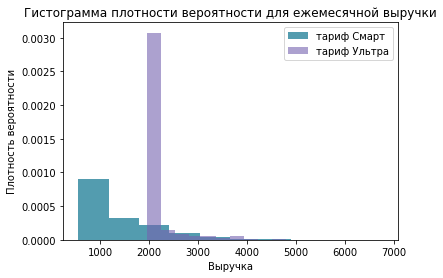

In [89]:
    _, ax = plt.subplots()
    ax.hist(data_smart['revenue'], color = "#539caf", alpha = 1, label = "тариф Смарт", density = True)
    ax.hist(data_ultra['revenue'], color = "#7663b0", alpha = 0.6, label = "тариф Ультра", density = True)
    ax.set_ylabel('Плотность вероятности')
    ax.set_xlabel('Выручка')
    ax.set_title('Гистограмма плотности вероятности для ежемесячной выручки')
    ax.legend(loc = 'best')

Распределение плотности вероятности для ежемесячной выручки для обоих тарифов экспоненциальное.

Гистограммы выручки для тарифов сильно отличаются, т.к. 75% пользователей тарифа Ультра хватает предложенного пакета. И они платят только абонентскую плату. 
Тогда как только 25% пользователей тарифа Смарт хватает предложенного пакета. И они расходуют средства помимо абонентской платы.

In [90]:
print('Средний расход минут в месяц для тарифа Смарт', data_smart['duration_round'].mean())
print('Дисперсия минут для тарифа Смарт', np.var(data_smart['duration_round'], ddof=1))
print('Стандартное отклонение минут для тарифа Смарт', np.std(data_smart['duration_round'], ddof=1))

Средний расход минут в месяц для тарифа Смарт 419.0629779577148
Дисперсия минут для тарифа Смарт 35844.1895513438
Стандартное отклонение минут для тарифа Смарт 189.3256177894154


In [91]:
print('Средний расход минут в месяц для тарифа Ультра', data_ultra['duration_round'].mean())
print('Дисперсия минут для тарифа Ультра', np.var(data_ultra['duration_round'], ddof=1))
print('Стандартное отклонение минут для тарифа Ультра', np.std(data_ultra['duration_round'], ddof=1))

Средний расход минут в месяц для тарифа Ультра 545.4511041009464
Дисперсия минут для тарифа Ультра 94203.41839614812
Стандартное отклонение минут для тарифа Ультра 306.92575388218586


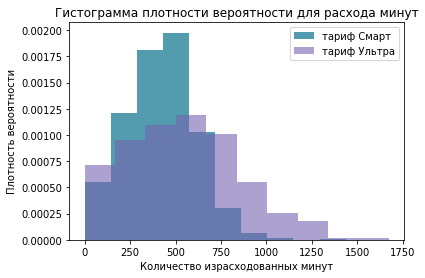

In [92]:
    _, ax = plt.subplots()
    ax.hist(data_smart['duration_round'], color = "#539caf", alpha = 1, label = "тариф Смарт", density = True)
    ax.hist(data_ultra['duration_round'], color = "#7663b0", alpha = 0.6, label = "тариф Ультра", density = True)
    ax.set_ylabel('Плотность вероятности')
    ax.set_xlabel('Количество израсходованных минут')
    ax.set_title('Гистограмма плотности вероятности для расхода минут')
    ax.legend(loc = 'best')

Для тарифа Смарт наблюдается левосторонняя ассиметрия в распределении расхода минут (медиана немного больше среднего). Распределение расхода минут для тарифа Ультра больше напоминает Пуассоновское за счёт мЕньшего количества наблюдений, но стремится к нормальному.

Более 25% пользователей тарифа Смарт не хватает минут, включённых в пакет.
Никому из пользователей тарифа Ультра не нужно столько минут, сколько предоставляется в пакете (максимальный расход - 1673 минуты в месяц против 3000 минут, предоставляемых по тарифу)

In [93]:
print('Среднее количество звонков в месяц для тарифа Смарт', data_smart['calls_count'].mean())
print('Дисперсия количества звонков для тарифа Смарт', np.var(data_smart['calls_count'], ddof=1))
print('Стандартное отклонение количества звонков для тарифа Смарт', np.std(data_smart['calls_count'], ddof=1))

Среднее количество звонков в месяц для тарифа Смарт 58.62123256860099
Дисперсия количества звонков для тарифа Смарт 665.4388289031333
Стандартное отклонение количества звонков для тарифа Смарт 25.796101040721897


In [94]:
print('Средний количество звонков в месяц для тарифа Ультра', data_ultra['calls_count'].mean())
print('Дисперсия количества звонков для тарифа Ультра', np.var(data_ultra['calls_count'], ddof=1))
print('Стандартное отклонение количества звонков для тарифа Ультра', np.std(data_ultra['calls_count'], ddof=1))

Средний количество звонков в месяц для тарифа Ультра 76.01682439537329
Дисперсия количества звонков для тарифа Ультра 1798.043927168078
Стандартное отклонение количества звонков для тарифа Ультра 42.40334806554876


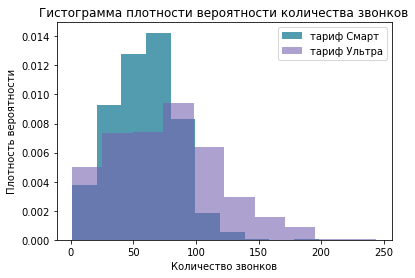

In [95]:
    _, ax = plt.subplots()
    ax.hist(data_smart['calls_count'], color = "#539caf", alpha = 1, label = "тариф Смарт", density = True)
    ax.hist(data_ultra['calls_count'], color = "#7663b0", alpha = 0.6, label = "тариф Ультра", density = True)
    ax.set_ylabel('Плотность вероятности')
    ax.set_xlabel('Количество звонков')
    ax.set_title('Гистограмма плотности вероятности количества звонков')
    ax.legend(loc = 'best')

Очертания гистограмм для количества звонков почти совпадают с гистограммами для количества минут.
Т.е. для тарифа Смарт наблюдается левосторонняя ассиметрия в распределении количества звонков. Распределение звонков для тарифа Ультра больше напоминает Пуассоновское за счёт мЕньшего количества наблюдений, но стремится к нормальному.

In [96]:
print('Средний интернет-трафик в Гб в месяц для тарифа Смарт', data_smart['gb_used'].mean())
print('Дисперсия интернет-трафика для тарифа Смарт', np.var(data_smart['gb_used'], ddof=1))
print('Стандартное отклонение интернет-трафика для тарифа Смарт', np.std(data_smart['gb_used'], ddof=1))

Средний интернет-трафик в Гб в месяц для тарифа Смарт 16.36669658886894
Дисперсия интернет-трафика для тарифа Смарт 33.05496582258378
Стандартное отклонение интернет-трафика для тарифа Смарт 5.749344816810328


In [97]:
print('Средний интернет-трафик в Гб в месяц для тарифа Ультра', data_ultra['gb_used'].mean())
print('Дисперсия интернет-трафика для тарифа Ультра', np.var(data_ultra['gb_used'], ddof=1))
print('Стандартное отклонение интернет-трафика для тарифа Ультра', np.std(data_ultra['gb_used'], ddof=1))

Средний интернет-трафик в Гб в месяц для тарифа Ультра 19.726153846153846
Дисперсия интернет-трафика для тарифа Ультра 94.37975675248776
Стандартное отклонение интернет-трафика для тарифа Ультра 9.714924433699306


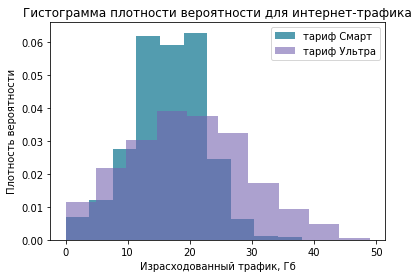

In [98]:
    _, ax = plt.subplots()
    ax.hist(data_smart['gb_used'], color = "#539caf", alpha = 1, label = "тариф Смарт", density = True)
    ax.hist(data_ultra['gb_used'], color = "#7663b0", alpha = 0.6, label = "тариф Ультра", density = True)
    ax.set_ylabel('Плотность вероятности')
    ax.set_xlabel('Израсходованный трафик, Гб')
    ax.set_title('Гистограмма плотности вероятности для интернет-трафика')
    ax.legend(loc = 'best')

Для тарифа Смарт наблюдается небольшая левосторонняя ассиметрия в распределении расходования интернет-трафика. 
Но в целом оба распределения близки к нормальным.

Больше, чем половине пользователей тарифа Смарт и почти 25% пользователей тарифа Ультра не хватает предложенного пакета интернет-трафика.
Для повышения лояльности клиентов компании Мегалайн можно было бы подумать о небольшом увеличении пакета интернет-трафика для тарифа Смарт и возможности подключения безлимитного интернета для тарифа Ультра.

In [99]:
print('Среднее количество смс в месяц для тарифа Смарт', data_smart['sms_count'].mean())
print('Дисперсия смс для тарифа Смарт', np.var(data_smart['sms_count'], ddof=1))
print('Стандартное отклонение смс для тарифа Смарт', np.std(data_smart['sms_count'], ddof=1))

Среднее количество смс в месяц для тарифа Смарт 38.71644120707596
Дисперсия смс для тарифа Смарт 717.5942011753547
Стандартное отклонение смс для тарифа Смарт 26.787948804926344


In [100]:
print('Среднее количество смс в месяц для тарифа Ультра', data_ultra['sms_count'].mean())
print('Дисперсия смс для тарифа Ультра', np.var(data_ultra['sms_count'], ddof=1))
print('Стандартное отклонение смс для тарифа Улььтра', np.std(data_ultra['sms_count'], ddof=1))

Среднее количество смс в месяц для тарифа Ультра 61.161006289308176
Дисперсия смс для тарифа Ультра 2109.6591828651995
Стандартное отклонение смс для тарифа Улььтра 45.93102636416042


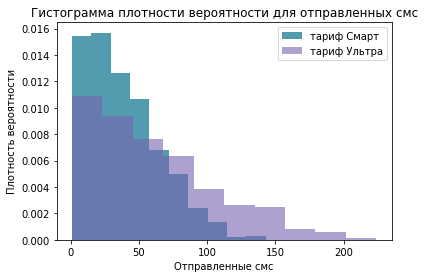

In [101]:
    _, ax = plt.subplots()
    ax.hist(data_smart['sms_count'], color = "#539caf", alpha = 1, label = "тариф Смарт", density = True)
    ax.hist(data_ultra['sms_count'], color = "#7663b0", alpha = 0.6, label = "тариф Ультра", density = True)
    ax.set_ylabel('Плотность вероятности')
    ax.set_xlabel('Отправленные смс')
    ax.set_title('Гистограмма плотности вероятности для отправленных смс')
    ax.legend(loc = 'best')

Наблюдается сильно выраженная ассиметрия в распределении числа отправленных смс.

Распределение геометрическое.

Многие пользователи уже почти не отправляют смс.

***Вывод:***
Более 25% пользователей тарифа Смарт не хватает минут и смс, включённых в пакет.

Никому из пользователей тарифа Ультра не нужно столько минут, сколько предоставляется в пакете (максимальный расход - 1673 минуты в месяц против 3000 минут, предоставляемых по тарифу); то же касается и смс (максимальный расход - 224 смс/мес. против 1000, предоставляемых в пакете). Компании Мегалайн можно порекомендовать создать тариф с промежуточным количеством минут и смс, чтобы сохранить лояльность пользователей. 

Больше, чем половине пользователей тарифа Смарт и почти 25% пользователей тарифа Ультра не хватает предложенного пакета интернет-трафика.

Для повышения лояльности клиентов компании Мегалайн можно было бы подумать о небольшом увеличении пакета интернет-трафика для тарифа Смарт и возможности подключения безлимитного интернета для тарифа Ультра.

А также поговорить с клиентами, расход трафиков которых не соответствует условиям выбранного тарифа.

В целом 75% пользователей тарифа Ультра хватает предложенного пакета. И они платят только абонентскую плату. 

Тогда как только 25% пользователей тарифа Смарт хватает предложенного пакета. И они расходуют средства помимо абонентской платы.


<a id="assumption"></a>
## 4. Проверка гипотез


Чтобы проверить, различаются ли средние выручки для тарифов Смарт и Ультра по взятым из них выборкам, сформулируем и проверим следующие статистические гипотезы:
- нулевая гипотеза H₀: среднее генеральной совокупности тарифа Смарт равно средней генеральной совокупности тарифа Ультра;
- альтернативная гипотеза H₁: среднее генеральной совокупности тарифа Смарт не равно средней генеральной совокупности тарифа Ультра.
Установим уровень значимости alpha = 0.05 
Если p-value окажется меньше него - отвергнем гипотезу H₀
Установим параметр equal_var = False, т.к. предполагаем, что дисперсии генеральных совокупностей различаются.
Используем t-тест Стьюдента для проверки гипотез.

In [102]:
alpha = .05
results = st.ttest_ind(data_smart['revenue'], data_ultra['revenue'], equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что средняя выручка тарифа Смарт равна средней выручке тарифа Ультра

Чтобы проверить, различаются ли средние выручки в Москве и регионах, создадим срезы по Москве и регионам для обоих тарифов:

In [103]:
data_smart_moscow = data_smart.query('city == "Москва"')
data_smart_regions = data_smart.query('city != "Москва"')
data_ultra_moscow = data_ultra.query('city == "Москва"')
data_ultra_regions = data_ultra.query('city != "Москва"')

In [104]:
data_smart_moscow.sample(5)

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
1547,1248,7,740.000,111.000,13581.000,14.000,nan,51,2018-12-31,Москва,Анатолий,Минаев,2018-05-28,smart,5,720.000,0.000,0.000,1270.000
433,1067,9,554.000,70.000,12776.000,13.000,47.000,45,2018-12-31,Москва,Юзефа,Абашкина,2018-04-09,smart,4,162.000,0.000,0.000,712.000
2081,1332,6,603.000,82.000,20023.000,20.000,38.000,23,2018-12-31,Москва,Джозефина,Тетерина,2018-05-28,smart,5,309.000,1000.000,0.000,1859.000
2163,1345,8,281.000,31.000,23673.000,24.000,3.000,31,2018-12-31,Москва,Галина,Ёркина,2018-06-01,smart,6,0.000,1800.000,0.000,2350.000
2778,1435,5,401.000,58.000,23008.000,23.000,nan,32,2018-12-31,Москва,Евфросинья,Азимова,2018-02-17,smart,2,0.000,1600.000,0.000,2150.000


In [105]:
data_smart_regions.sample(5)

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
574,1092,10,470.000,68.000,24312.000,24.000,51.000,73,2018-12-31,Ижевск,Вениамин,Амельченко,2018-06-19,smart,6,0.000,1800.000,3.000,2353.000
449,1071,1,194.000,24.000,15622.000,16.000,16.000,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,1,0.000,200.000,0.000,750.000
1574,1251,9,443.000,62.000,20399.000,20.000,93.000,48,2018-12-31,Пермь,Роксана,Тетерина,2018-02-13,smart,2,0.000,1000.000,129.000,1679.000
1743,1280,8,779.000,99.000,16239.000,16.000,42.000,53,2018-12-31,Астрахань,Артемий,Худяков,2018-07-18,smart,7,837.000,200.000,0.000,1587.000
911,1147,8,243.000,33.000,20152.000,20.000,36.000,63,2018-12-31,Якутск,Владимир,Синицын,2018-07-09,smart,7,0.000,1000.000,0.000,1550.000


In [106]:
data_ultra_moscow.sample(5)

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
2071,1331,4,275.000,43.000,20018.000,20.000,49.000,26,2018-12-31,Москва,Юлия,Малинина,2018-04-12,ultra,4,0,0.000,0,1950.000
303,1049,6,520.000,76.000,7604.000,8.000,nan,41,2018-12-31,Москва,Габриель,Ларин,2018-03-10,ultra,3,0,0.000,0,1950.000
2811,1440,6,270.000,37.000,19825.000,20.000,113.000,51,2018-12-31,Москва,Арсений,Матвеев,2018-05-28,ultra,5,0,0.000,0,1950.000
300,1049,3,403.000,55.000,6201.000,7.000,nan,41,2018-12-31,Москва,Габриель,Ларин,2018-03-10,ultra,3,0,0.000,0,1950.000
2383,1379,10,964.000,130.000,25763.000,26.000,129.000,39,2018-12-31,Москва,Нелли,Кочергина,2018-08-09,ultra,8,0,0.000,0,1950.000


In [107]:
data_ultra_regions.sample(5)

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
1692,1272,8,20.000,4.000,3435.000,4.000,7.000,61,2018-12-31,Пенза,Мстислав,Демьянов,2018-08-29,ultra,8,0,0.000,0,1950.000
919,1148,7,936.000,122.000,35158.000,35.000,20.000,23,2018-12-31,Тольятти,Евдокия,Киреева,2018-04-17,ultra,4,0,750.000,0,2700.000
2038,1325,11,548.000,84.000,27488.000,27.000,13.000,63,2018-12-31,Новосибирск,Артём,Федосеев,2018-06-12,ultra,6,0,0.000,0,1950.000
556,1089,2,5.000,2.000,2869.000,3.000,27.000,19,2018-12-31,Иркутск,Ксения,Нечаева,2018-02-24,ultra,2,0,0.000,0,1950.000
2741,1430,7,322.000,45.000,21376.000,21.000,46.000,22,2018-12-31,Тверь,Андрей,Авроров,2018-04-23,ultra,4,0,0.000,0,1950.000


In [108]:
data_smart_moscow.describe()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
count,386.000,386.000,386.000,386.000,386.000,386.000,293.000,386.000,386.000,386.000,386.000,386.000,386.000
mean,1251.008,8.573,417.482,58.236,16038.513,16.194,36.587,44.184,5.176,118.360,564.767,11.930,1245.057
std,133.949,2.857,177.403,24.154,5618.600,5.503,23.768,17.669,3.074,231.507,693.122,31.732,755.005
min,1001.000,1.000,12.000,2.000,374.000,1.000,1.000,18.000,1.000,0.000,0.000,0.000,550.000
25%,1157.000,7.000,290.000,40.000,12568.000,13.000,20.000,28.250,2.000,0.000,0.000,0.000,550.000
50%,1260.000,9.000,408.000,57.500,16173.500,16.000,31.000,45.000,5.000,0.000,200.000,0.000,1011.500
75%,1343.500,11.000,544.000,76.000,19876.000,20.000,49.000,58.000,7.000,132.000,1000.000,0.000,1681.750
max,1490.000,12.000,1022.000,128.000,35151.000,35.000,109.000,73.000,12.000,1566.000,4000.000,177.000,5321.000


In [109]:
data_smart_regions.describe()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
count,1843.000,1843.000,1837.000,1837.000,1842.000,1842.000,1629.000,1843.000,1843.000,1843.000,1843.000,1843.000,1843.000
mean,1245.564,8.300,419.395,58.702,16277.956,16.403,39.099,47.053,4.671,126.169,610.309,18.545,1305.024
std,148.559,2.932,191.781,26.134,5920.556,5.800,27.285,16.025,2.955,258.544,748.710,41.822,833.901
min,1002.000,1.000,0.000,1.000,0.000,0.000,1.000,19.000,1.000,0.000,0.000,0.000,550.000
25%,1119.000,6.000,285.000,40.000,12732.750,13.000,16.000,34.000,2.000,0.000,0.000,0.000,553.000
50%,1232.000,9.000,427.000,60.000,16595.000,17.000,34.000,47.000,4.000,0.000,400.000,0.000,1040.000
75%,1378.000,11.000,546.000,76.000,20092.500,20.000,56.000,62.000,7.000,136.500,1000.000,6.000,1765.000
max,1499.000,12.000,1435.000,198.000,38610.000,38.000,143.000,75.000,12.000,2805.000,4600.000,279.000,6770.000


In [110]:
data_ultra_moscow.describe()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
count,225.000,225.000,224.000,224.000,225.000,225.000,198.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,1299.520,8.191,560.281,78.138,21321.778,21.338,62.742,46.147,4.538,0.000,125.333,0.000,2075.333
std,138.480,2.931,302.155,41.645,9794.176,9.535,44.053,16.938,2.774,0.000,353.052,0.000,353.052
min,1003.000,1.000,1.000,1.000,366.000,1.000,3.000,20.000,1.000,0.000,0.000,0.000,1950.000
25%,1203.000,6.000,356.000,50.750,13764.000,14.000,26.250,30.000,3.000,0.000,0.000,0.000,1950.000
50%,1341.000,9.000,554.500,77.000,21493.000,21.000,53.000,42.000,4.000,0.000,0.000,0.000,1950.000
75%,1415.000,11.000,762.500,105.000,28703.000,29.000,93.750,55.000,6.000,0.000,0.000,0.000,1950.000
max,1476.000,12.000,1321.000,188.000,44341.000,44.000,191.000,75.000,11.000,0.000,2100.000,0.000,4050.000


In [111]:
data_ultra_regions.describe()

,user_id,month,duration_round,calls_count,mb_used_round,gb_used,sms_count,age,reg_month,revenue_calls,revenue_internet,revenue_sms,revenue
count,760.000,760.000,727.000,727.000,750.000,750.000,597.000,760.000,760.000,760.000,760.000,760.000,760.000
mean,1252.311,8.268,540.882,75.363,19196.264,19.243,60.637,47.038,4.657,0.000,119.803,0.000,2069.803
std,139.620,2.856,308.443,42.641,9953.093,9.723,46.561,17.164,2.723,0.000,386.310,0.000,386.310
min,1000.000,1.000,0.000,1.000,0.000,0.000,1.000,18.000,1.000,0.000,0.000,0.000,1950.000
25%,1124.000,6.000,304.500,42.000,11791.500,12.000,24.000,30.000,2.000,0.000,0.000,0.000,1950.000
50%,1265.000,9.000,518.000,74.000,18639.000,19.000,50.000,46.000,4.000,0.000,0.000,0.000,1950.000
75%,1375.000,11.000,754.000,105.000,26008.000,26.000,85.000,63.000,6.000,0.000,0.000,0.000,1950.000
max,1495.000,12.000,1673.000,244.000,49789.000,49.000,224.000,74.000,12.000,0.000,2850.000,0.000,4800.000


In [112]:
print('Средняя выручка по тарифу Смарт в Москве', data_smart_moscow['revenue'].mean())
print('Средняя выручка по тарифу Смарт в регионах', data_smart_regions['revenue'].mean())
print('Средняя выручка по тарифу Ультра в Москве', data_ultra_moscow['revenue'].mean())
print('Средняя выручка по тарифу Ультра в регионах', data_ultra_regions['revenue'].mean())

Средняя выручка по тарифу Смарт в Москве 1245.0569948186528
Средняя выручка по тарифу Смарт в регионах 1305.0238741182854
Средняя выручка по тарифу Ультра в Москве 2075.3333333333335
Средняя выручка по тарифу Ультра в регионах 2069.8026315789475


Теперь проверим 2 гипотезы:
1. различаются ли средние выручки для Москвы и регионов для тарифа Смарт по взятым из них выборкам, для этого сформулируем и проверим следующие статистические гипотезы:
    - нулевая гипотеза H₀: среднее генеральной совокупности для Москвы для тарифа Смарт равно средней генеральной совокупности для регионов для тарифа Смарт;
    - альтернативная гипотеза H₁: среднее генеральной совокупности для Москвы для тарифа Смарт не равно средней генеральной совокупности для регионов для тарифа Смарт
2. различаются ли средние выручки для Москвы и регионов для тарифа Ультра по взятым из них выборкам, для этого сформулируем и проверим следующие статистические гипотезы:
    - нулевая гипотеза H₀: среднее генеральной совокупности для Москвы для тарифа Ультра равно средней генеральной совокупности для регионов для тарифа Ультра;
    - альтернативная гипотеза H₁: среднее генеральной совокупности для Москвы для тарифа Ультра не равно средней генеральной совокупности для регионов для тарифа Ультра
    
Установим уровень значимости alpha = 0.05 
Если p-value окажется меньше него - отвергнем гипотезу H₀
Установим параметр equal_var = True, т.к. предполагаем, что дисперсии генеральных совокупностей схожи, ведь рассмотрение идёт в пределах одного тарифного плана.

In [113]:
alpha = .05
results = st.ttest_ind(data_smart_moscow['revenue'], data_smart_regions['revenue'])
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.19196326570657848
Не получилось отвергнуть нулевую гипотезу


In [114]:
alpha = .05
results = st.ttest_ind(data_ultra_moscow['revenue'], data_ultra_regions['revenue'])
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8475623384854951
Не получилось отвергнуть нулевую гипотезу


Нельзя отвергнуть нулевую гипотезу о равенстве средних выручек по Москве и регионам как для тарифа Смарт, так и для тарифа Ультра.
Что логично, т.к. абонентская плата по регионам у данного оператора одинакова.

***Вывод***

- Была отвергнута нулевая гипотеза о том, что средняя выручка тарифа Смарт равна средней выручке тарифа Ультра
- Нельзя отвергнуть нулевую гипотезу о равенстве средних выручек по Москве и регионам как для тарифа Смарт, так и для тарифа Ультра.

<a id="finalizing"></a>
## 5. Общий вывод

В ходе данной работы были проанализированы два тарифа оператора сотовой связи - компании Мегалайн: Смарт и Ультра. 

В результате анализа можно сделать следующие выводы:
- Более 25% пользователей тарифа Смарт не хватает минут и смс, включённых в пакет.
- Никому из пользователей тарифа Ультра не нужно столько минут, сколько предоставляется в пакете (максимальный расход - 1673 минуты в месяц против 3000 минут, предоставляемых по тарифу); то же касается и смс (максимальный расход - 224 смс/мес. против 1000, предоставляемых в пакете).
- Больше, чем половине пользователей тарифа Смарт и почти 25% пользователей тарифа Ультра не хватает предложенного пакета интернет-трафика.
- В целом 75% пользователей тарифа Ультра хватает предложенного пакета. И они платят только абонентскую плату. Тогда как только 25% пользователей тарифа Смарт хватает предложенного пакета. И они расходуют средства помимо абонентской платы.
- Была отвергнута нулевая гипотеза о том, что средняя выручка тарифа Смарт равна средней выручке тарифа Ультра.
- Нельзя отвергнуть нулевую гипотезу о равенстве средних выручек по Москве и регионам как для тарифа Смарт, так и для тарифа Ультра.

В целом выручка от отдельного пользователя тарифа Ультра выше выручки от пользователя тарифа Смарт. Однако на наш взгляд нельзя в рекламе делать упор на этот тариф, т.к. его абонентская плата завышена, пользователям не нужны такие большие пакеты смс и минут. И меньшее количество клиентов готовы оплачивать данный тариф.

В то же время только 25% пользователей тарифа Смарт хватает предложенного пакета. И клиенты тратят почти в 2 раза больше заявленной абонентской платы.

Компании Мегалайн можно порекомендовать:
1. Создать и оценить метрики уровня счастья и лояльности клиентов, чтобы подтвердить наши предположения о недовольстве клиентов.
2. В случае подтверждения данного предположения создать тариф с промежуточным количеством минут и смс, чтобы сохранить лояльность пользователей.  Как вариант можно было бы подумать о предложении дополнительного пакета интернет-трафика для тарифа Смарт и возможности подключения безлимитного интернета для тарифа Ультра. Кроме того, можно рассмотреть возможность создания настраиваемых под потребности пользователей тарифов, чтобы сохранить конкурентоспособность на рынке операторов сотовой связи.
3. После чего поговорить с клиентами, расход трафиков которых не соответствует условиям выбранного тарифа, о смене тарифного плана.
4. Рекламный бюджет направить на рекламу нового удобного тарифа.
